In [2]:
import pandas as pd
import numpy as np
# import ydata_profiling
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import os
from math import pi
from matplotlib.path import Path
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D
import json

import warnings
warnings.filterwarnings('ignore')

## 공통 전처리

In [3]:
%%time
dtype = {
    'userID': 'int16',
    'answerCode': 'int8',
    'KnowledgeTag': 'int16'
}   

# data set load
DATA_PATH = '/opt/ml/input/data'
train_path = os.path.join(DATA_PATH, 'train_data.csv')
test_path = os.path.join(DATA_PATH, 'test_data.csv')

train_df = pd.read_csv(train_path, dtype=dtype, parse_dates=['Timestamp'])
test_df = pd.read_csv(test_path, dtype=dtype, parse_dates=['Timestamp'])

diff_train = train_df.loc[:, ['userID', 'Timestamp']].groupby('userID').diff().shift(-1)

# total_seconds(): 모든 속성을 초단위로 모아서 변환
diff_train = diff_train['Timestamp'].apply(lambda x: x.total_seconds())

train_df['elapsed'] = diff_train



test_df = pd.read_csv('/opt/ml/input/data/test_data.csv', dtype=dtype, parse_dates=['Timestamp'])


diff_test = test_df.loc[:, ['userID', 'Timestamp']].groupby('userID').diff().shift(-1)

# total_seconds(): 모든 속성을 초단위로 모아서 변환
diff_test = diff_test['Timestamp'].apply(lambda x: x.total_seconds())

test_df['elapsed'] = diff_test
test_df = test_df[test_df['answerCode'] != -1]
test_df = test_df.sort_values(by=['userID', 'Timestamp']).reset_index(drop=True)


df = pd.concat([train_df, test_df])
# df = df.drop(df[df['answerCode']== -1].index) # answerCode = -1 는 예측해야하는 값이므로 제외'Affine

import pytz
kst = pytz.timezone('Asia/Seoul')
df['Timestamp'] = df['Timestamp'].dt.tz_localize('UTC').dt.tz_convert(kst)

CPU times: user 9.58 s, sys: 944 ms, total: 10.5 s
Wall time: 10.5 s


### Feature Engineering
testID의 1~3번째 자리를 이용한 대분류인 testCode 생성

In [12]:
df['testCode'] = df['testId'].apply(lambda x : x[1:4])

#testCode 1~9의 정수형 값으로 변환
df['testCode'] = df['testCode'].astype('int') //10

In [13]:
df

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,elapsed,testCode
0,0,A060001001,A060000001,1,2020-03-24 09:17:11+09:00,7224,3.0,6
1,0,A060001002,A060000001,1,2020-03-24 09:17:14+09:00,7225,8.0,6
2,0,A060001003,A060000001,1,2020-03-24 09:17:22+09:00,7225,7.0,6
3,0,A060001004,A060000001,1,2020-03-24 09:17:29+09:00,7225,7.0,6
4,0,A060001005,A060000001,1,2020-03-24 09:17:36+09:00,7225,11.0,6
...,...,...,...,...,...,...,...,...
259365,7439,A040197006,A040000197,1,2020-08-21 16:39:45+09:00,2132,4721258.0,4
259366,7439,A040130001,A040000130,0,2020-10-15 08:07:23+09:00,8832,18.0,4
259367,7439,A040130002,A040000130,1,2020-10-15 08:07:41+09:00,8832,21.0,4
259368,7439,A040130003,A040000130,1,2020-10-15 08:08:02+09:00,8244,89.0,4


## Overview

+ `userID` 사용자의 고유 번호입니다. 총 7,442명의 학생이 있습니다. 이 중 train data에는 6698명이, test data에는 744명이 존재합니다.   
+ `assessmentItemID` 사용자가 푼 문항의 일련 번호입니다.   
+ `testId` 사용자가 푼 문항이 포함된 시험지의 일련 번호입니다.   
+ `answerCode` 사용자가 푼 문항의 정답 여부를 담고 있는 이진 (0/1) 데이터입니다.   
+ `Timestamp` 사용자가 문항을 푼 시간 정보입니다.   
+ `KnowledgeTag` 사용자가 푼 문항의 고유 태그가 담겨져 있습니다.

In [5]:
print(f"""--- BASIC INFORMATIONS ---
userID           : {df.userID.nunique()}
assessmentItemID : {df.assessmentItemID.nunique()}
testID           : {df.testId.nunique()}
mean answer rate : {df.answerCode.sum() / df.shape[0] * 100:.2f}%
KnowledgeTag     : {df.KnowledgeTag.nunique()}
{'-'*26}""")

--- BASIC INFORMATIONS ---
userID           : 7442
assessmentItemID : 9454
testID           : 1537
mean answer rate : 65.46%
KnowledgeTag     : 912
--------------------------


0과 1의 데이터 분포 파악

Text(0.5, 1.0, 'Distribution of answerCode=0')

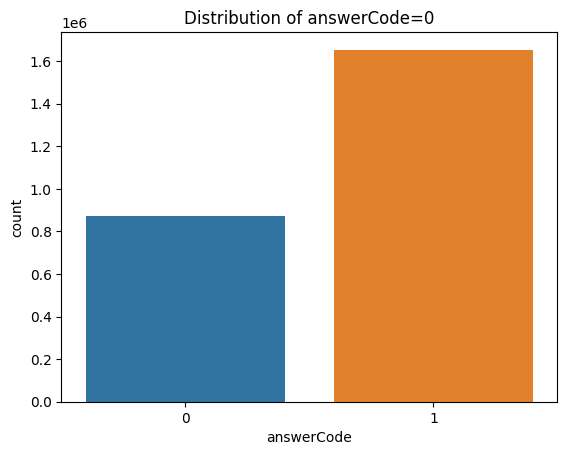

In [6]:
df.answerCode.value_counts()
sns.countplot(data=df, x='answerCode').set_title('Distribution of answerCode=0')

assessmentItemID의 맨 앞자리가 A로 시작하는지 확인

In [7]:
df['assessmentItemID'].apply(lambda x: x[0]).unique()

array(['A'], dtype=object)

testID의 맨 앞자리가 A로 시작하는지 확인

In [8]:
df['testId'].apply(lambda x: x[0]).unique()

array(['A'], dtype=object)

testID의 4~6번째 자리가 '000'인지 확인

In [9]:
df['testId'].apply(lambda x: x[4:7]).unique()

array(['000'], dtype=object)

assessmentItemID가 testID에 맞게 잘 이루어져있는지 확인

In [11]:
(df['assessmentItemID'].apply(lambda x: x[1:7]) != df['testId'].apply(lambda x: x[1:4] + x[7:])).sum()

0

### 사용되는 함수

In [18]:
#정답률을 빠르게 구하기 위해 함수 정의
def percentile(s):
    return np.sum(s) / len(s)

## 이상치 파악

## assessmentitem Id / test Id [희원, 찬웅]

### 문제번호에 따른 정답

### testcode

In [14]:
#각 testCode 별로 풀어진 횟수 count
df['testCode'].value_counts()

testCode
7    315177
5    306317
1    303675
3    303365
4    300403
2    297263
6    296284
8    271841
9    131631
Name: count, dtype: int64

대체적으로 골고루 문제가 풀어졌으며, 9번에 해당하는 코드만 적게 풀어진 것으로 확인

In [17]:
df_cor = df.copy()
df_cor = df_cor.loc[ : , ['testCode', 'answerCode']]
df_cor.corr()['testCode']['answerCode']

-0.2009546600276782

testCode를 기준으로 groupby 진행

In [20]:
code_groupby = df.groupby('testCode').agg({'answerCode' : percentile, 'assessmentItemID': 'nunique',
                                      'testId' : 'nunique', 'userID': 'nunique', 'KnowledgeTag' : 'nunique'})
code_groupby = code_groupby.reset_index()
code_groupby

,testCode,answerCode,assessmentItemID,testId,userID,KnowledgeTag
0,1,0.801686,975,192,2301,64
1,2,0.738023,1022,194,2481,70
2,3,0.702210,1060,198,2724,85
3,4,0.680256,1031,198,2974,81
4,5,0.659098,1266,193,2577,98
5,6,0.712279,1213,186,2364,93
6,7,0.521761,1322,164,1882,176
7,8,0.500826,1050,138,1693,150
8,9,0.454680,515,74,743,96


[Text(0.5, 1.0, 'Answer Rate by Test Code')]

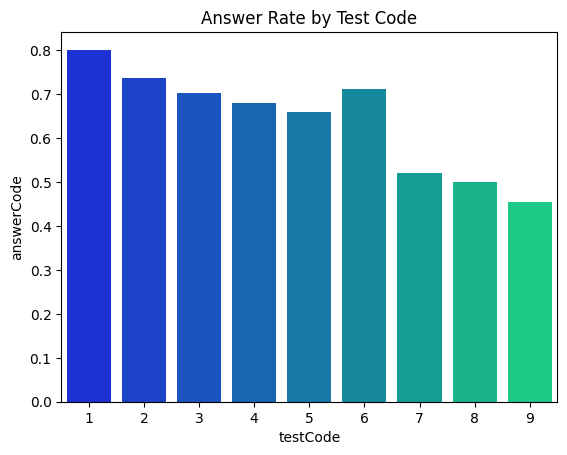

In [21]:
sns.barplot(x='testCode', y='answerCode', data=code_groupby, palette='winter').set(title='Answer Rate by Test Code')

비교적으로 testCode에 따라 선형적으로 정답률이 나옴  
가설 : testCode가 난이도를 의미할 수 있겠다.  
다만, 6의 정답률이 높은 이유에 대한 설명이 필요

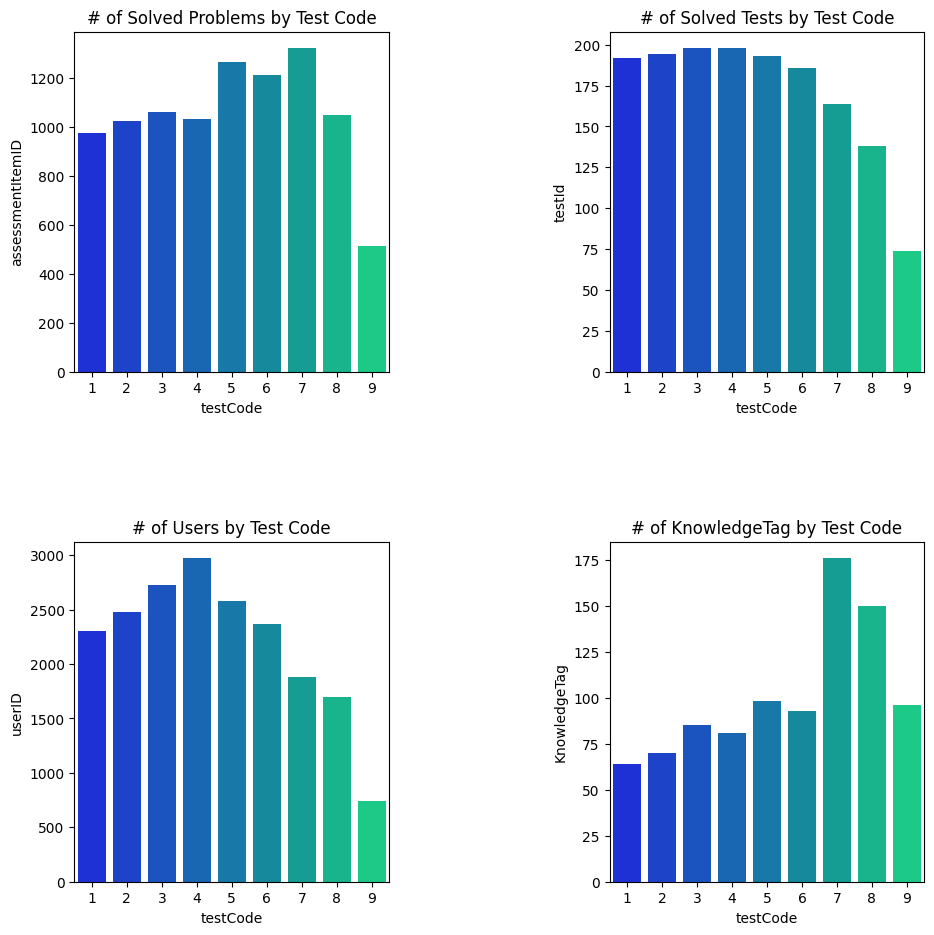

In [28]:
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)
ax3 = fig.add_subplot(2,2,3)
ax4 = fig.add_subplot(2,2,4)

sns.barplot(x='testCode', y='assessmentItemID', data=code_groupby, palette='winter', ax=ax1).set(title='# of Solved Problems by Test Code')
sns.barplot(x='testCode', y='testId', data=code_groupby, palette='winter', ax=ax2).set(title='# of Solved Tests by Test Code')
sns.barplot(x='testCode', y='userID', data=code_groupby, palette='winter', ax=ax3).set(title='# of Users by Test Code')
sns.barplot(x='testCode', y='KnowledgeTag', data=code_groupby, palette='winter', ax=ax4).set(title='# of KnowledgeTag by Test Code')

plt.subplots_adjust(left=0.1, right=0.95, bottom=0.1, top=0.95, wspace=0.7, hspace=0.5)
plt.show()

일부 학생을 선별하여 푼 문제의 testcode를 체크  
선별 기준:  
1. 푼 문제의 수가 많은 학생, 중간인 학생
2. 정답률이 높은 학생

In [42]:
stu_groupby = df.groupby('userID').agg({
    'assessmentItemID': 'count',
    'answerCode': percentile
})
stu_groupby

,assessmentItemID,answerCode
userID,,
0,745,0.630872
1,933,0.853162
2,276,0.612319
3,1035,0.692754
4,670,0.694030
...,...,...
7437,16,0.375000
7438,16,0.750000
7439,15,0.733333


In [43]:
samples = stu_groupby.sort_values(by='assessmentItemID', ascending=False).index[[0, 3300]]
samples

Index([730, 4663], dtype='int16', name='userID')

In [44]:
sample_df = df[df['userID'] == 730]

lv_sample = sample_df.groupby('testCode').agg({'assessmentItemID' : 'count', 'answerCode' : percentile})
lv_sample

,assessmentItemID,answerCode
testCode,,
4,325,0.483077
5,294,0.829932
7,1241,0.573731


In [47]:
sample_d2 = df[df['userID'] == 4663]
lv_sample2 = sample_d2.groupby('testCode').agg({'assessmentItemID' : 'count', 'answerCode' : percentile})

lv_sample2

,assessmentItemID,answerCode
testCode,,
5,140,0.578571
6,7,0.571429
7,140,0.842857


In [46]:
samples2 = stu_groupby.sort_values(by='answerCode', ascending=False).index[[0]]
samples2

Index([7171], dtype='int16', name='userID')

In [48]:
sample2_df = df[df['userID'] == 7171]
lv_sample3 = sample2_df.groupby('testCode').agg({'assessmentItemID' : 'count', 'answerCode' : percentile})

lv_sample3

,assessmentItemID,answerCode
testCode,,
1,10,1.0
6,10,1.0


세 학생 모두 3개 이하의 testCode만 푼 것을 확인  

제기했던 가설 : testCode가 학년에 따른 분류를 나타낼까?  
다양한 코드를 순서 상관없이 푸는 것으로 보아 학년에 의한 분류는 아닌 것으로 보여진다.

(여기 희원 오빠가 한 거 추가해주면 될 듯!)

## timestamp [현정, 희만, … ]

월별 평균, 총합, 개수

In [8]:
last_1M = df.groupby([pd.Grouper(freq='1M',key='Timestamp')])["answerCode"].agg(["mean", "sum", "count"])
last_1M

,mean,sum,count
Timestamp,,,
2020-01-31 00:00:00+09:00,0.706736,29449,41669
2020-02-29 00:00:00+09:00,0.686150,60268,87835
2020-03-31 00:00:00+09:00,0.682923,132371,193830
2020-04-30 00:00:00+09:00,0.649782,128931,198422
2020-05-31 00:00:00+09:00,0.643328,131522,204440
2020-06-30 00:00:00+09:00,0.652473,165259,253281
2020-07-31 00:00:00+09:00,0.666436,201425,302242
2020-08-31 00:00:00+09:00,0.657312,231763,352592
2020-09-30 00:00:00+09:00,0.670203,253542,378306


월별로 뽑아낸 데이터의 개수와 정답률

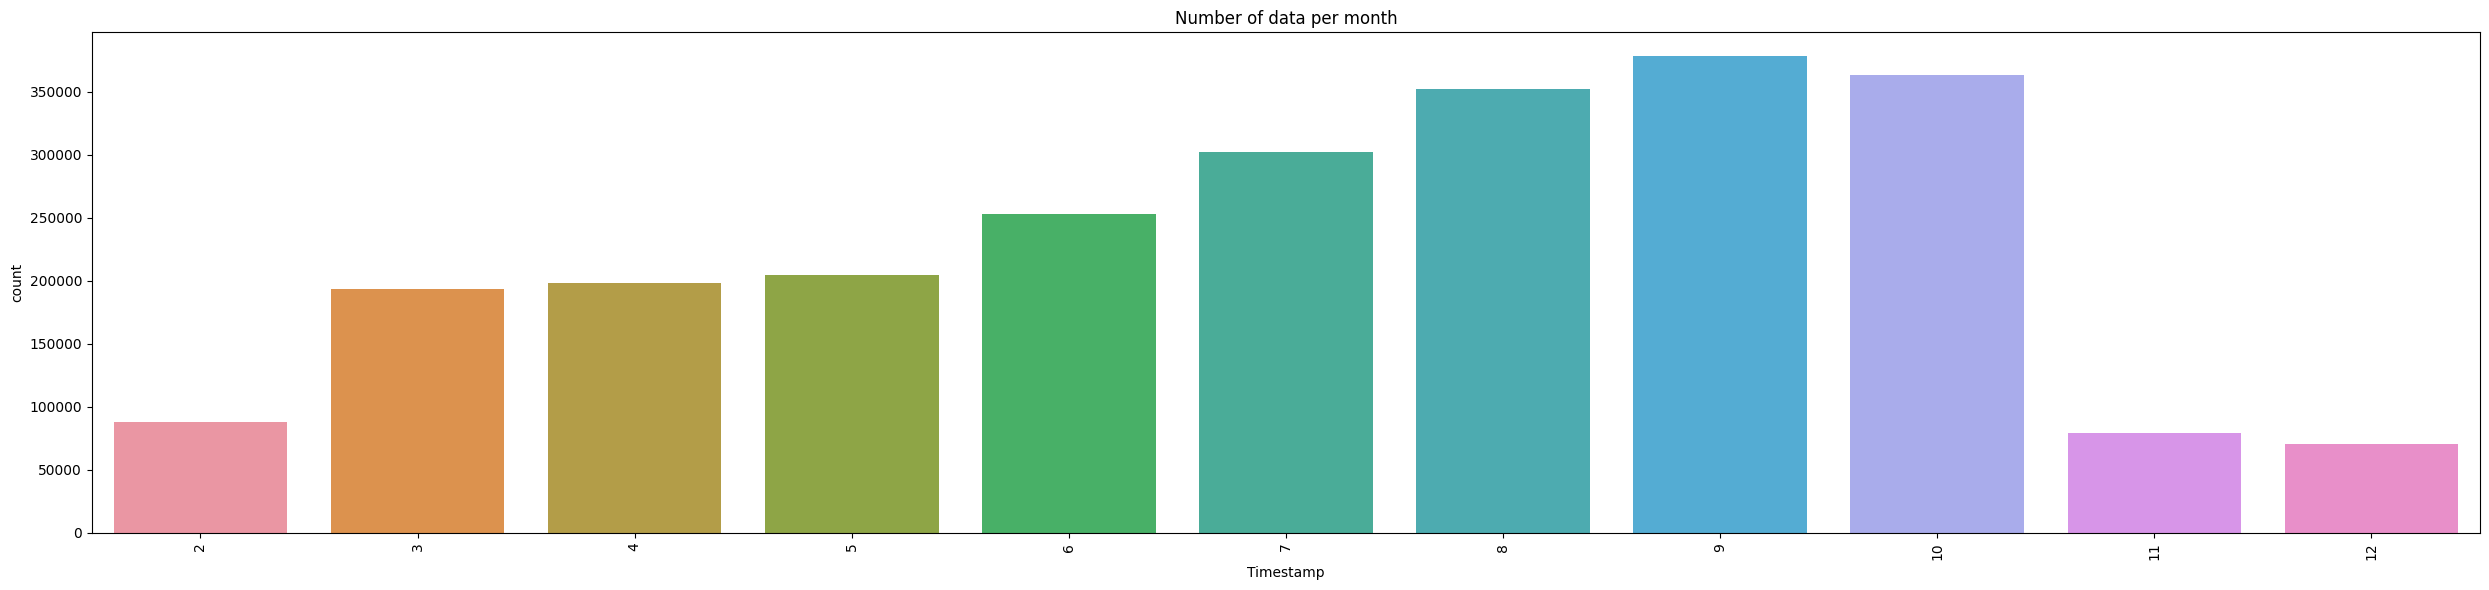

In [9]:
plt.figure(figsize=(25,6))
sns.barplot(x=last_1M[1:].index.month , y=last_1M[1:]['count'])
plt.xticks(rotation=90)
plt.title('Number of data per month')
plt.tight_layout()

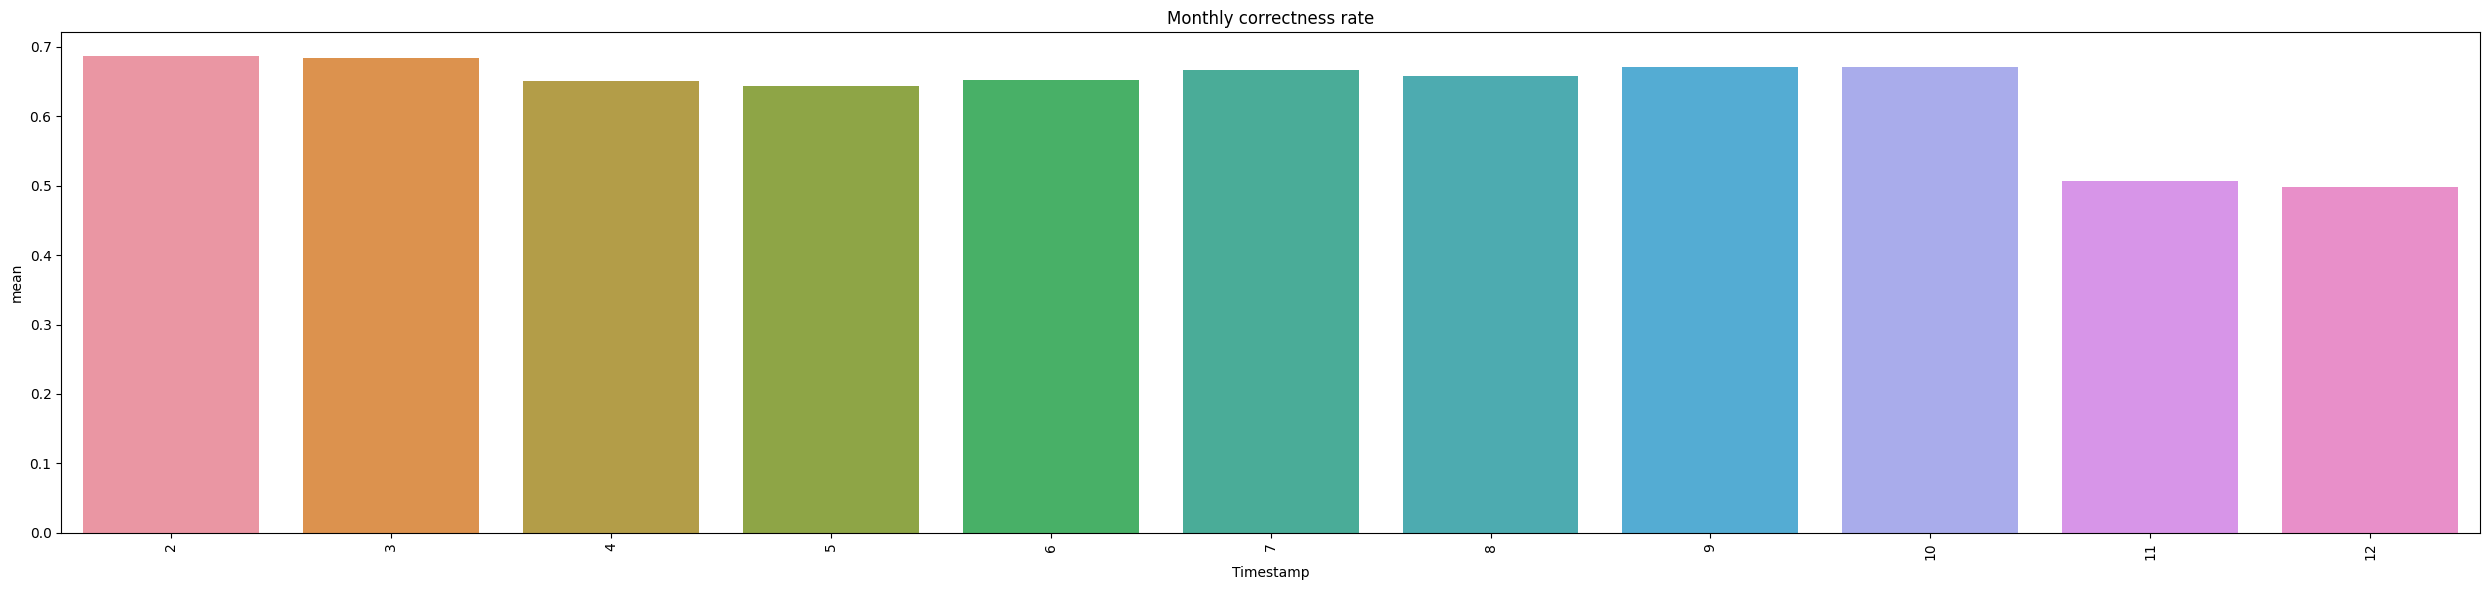

In [10]:
plt.figure(figsize=(25,6))
sns.barplot(x=last_1M[1:].index.month, y=last_1M[1:]['mean'])
plt.xticks(rotation=90)
plt.title('Monthly correctness rate')
plt.tight_layout()

시간대별로 추출

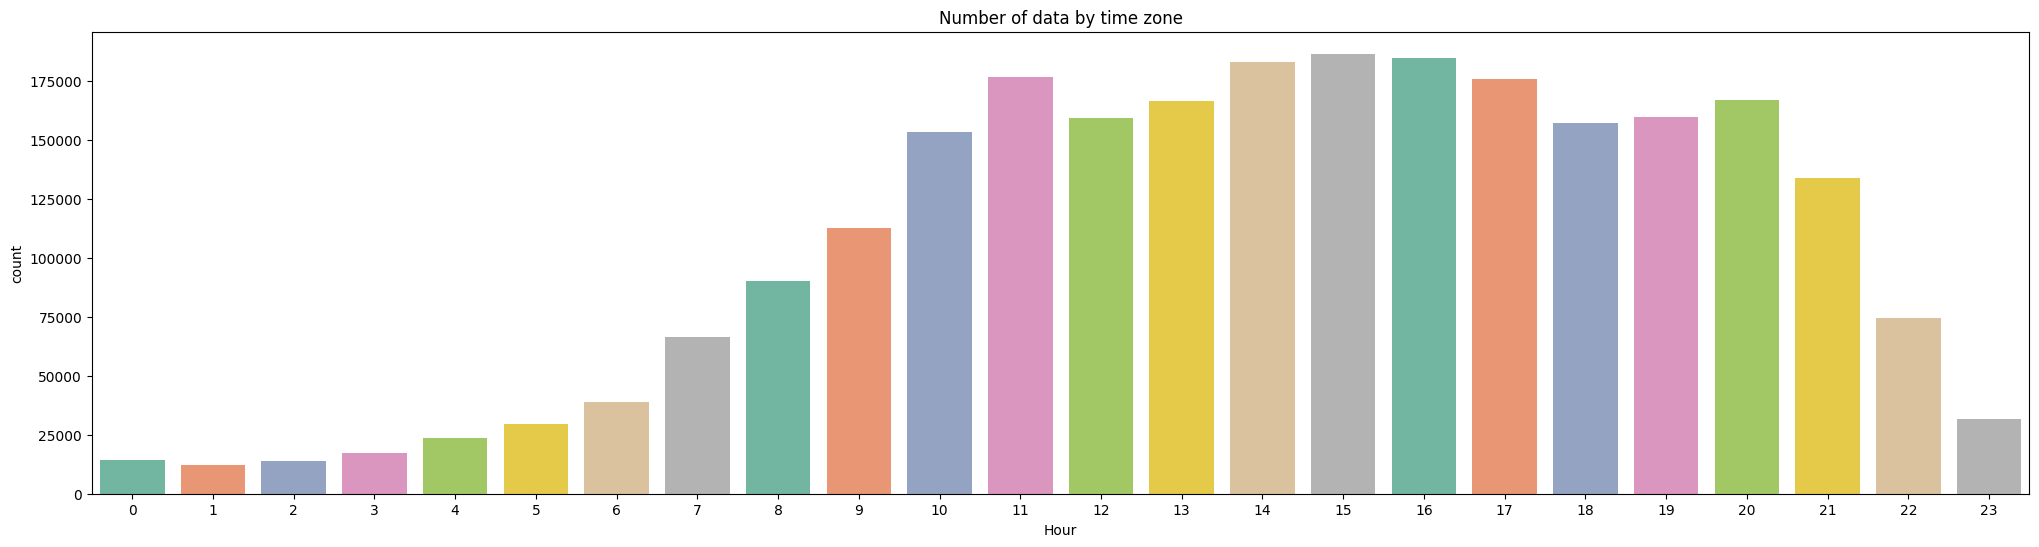

In [11]:
df['Hour'] = df['Timestamp'].dt.hour 
Hour_ans_rate = df.groupby(["Hour"])["answerCode"].agg(["mean", "count"]).reset_index()

plt.figure(figsize=(25,6))
sns.barplot(x="Hour", y="count", data=Hour_ans_rate, palette='Set2')
plt.title('Number of data by time zone')
plt.show()

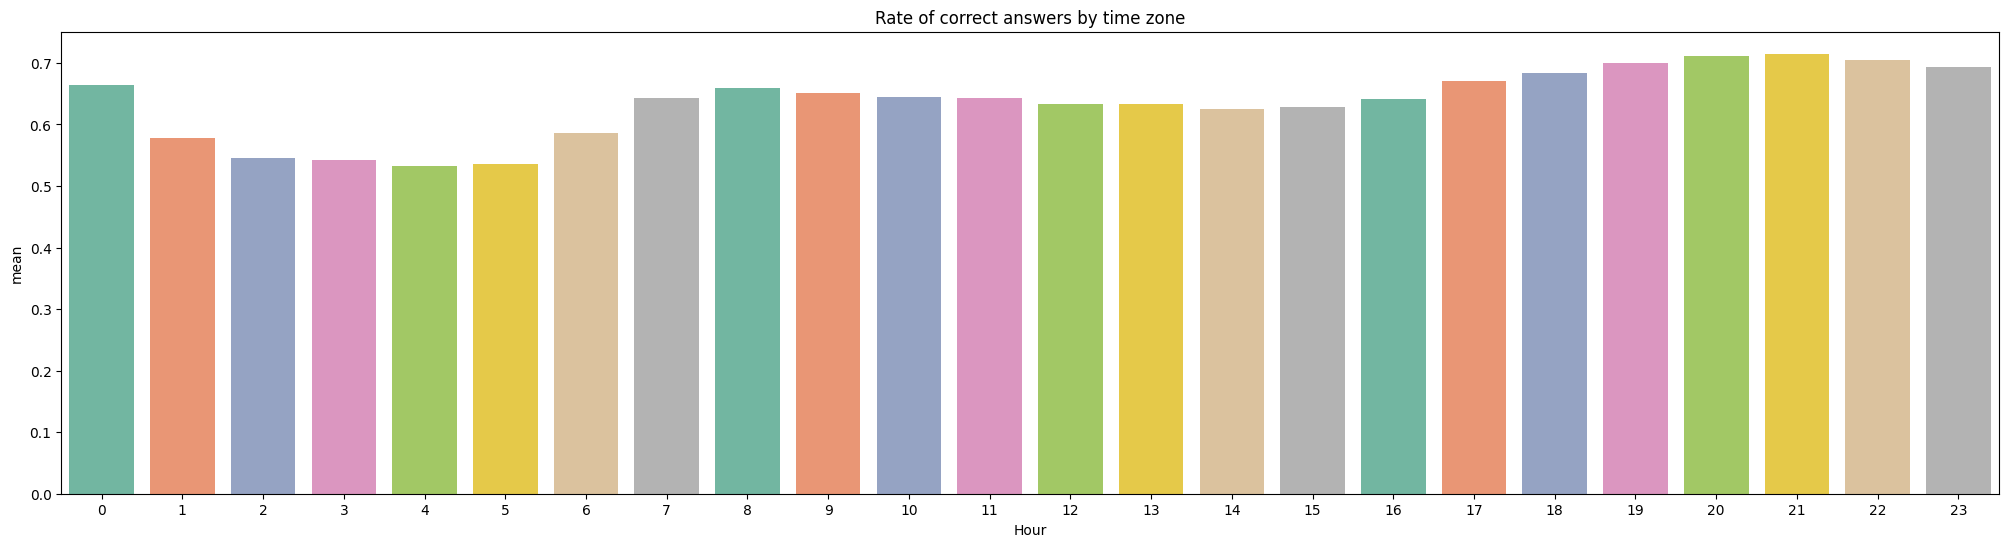

In [12]:
plt.figure(figsize=(25,6))
sns.barplot(x="Hour", y="mean", data=Hour_ans_rate, palette='Set2')
plt.title('Rate of correct answers by time zone')
plt.show()

시간대별 정답률 확인

In [13]:
bins = [0, 6, 12, 18, 24]
labels = ['0~5', '6~11', '12~17', '18~23']
df['hour_range'] = pd.cut(df['Hour'], bins=bins, labels=labels, include_lowest=True)

Hour_range_ans_rate = df.groupby(["hour_range"])["answerCode"].agg(["mean", "count"]).reset_index()

새벽시간에 더 적은 문제를 풀었음에도 평균이 상대적으로 낮은것을 확인가능

In [14]:
Hour_range_ans_rate

,hour_range,mean,count
0,0~5,0.565643,149423
1,6~11,0.644490,757332
2,12~17,0.646343,1053100
3,18~23,0.707137,566101


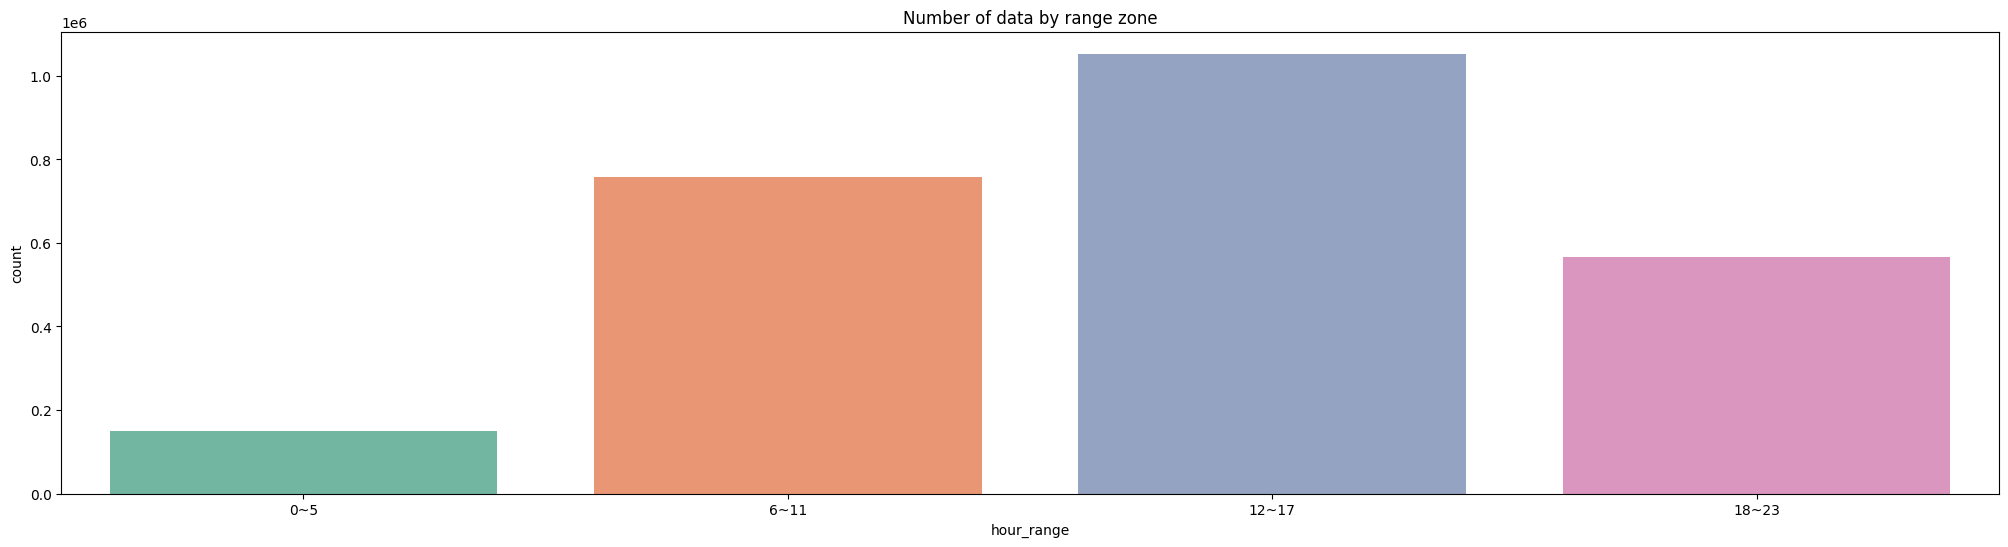

In [15]:
plt.figure(figsize=(25,6))
sns.barplot(x="hour_range", y="count", data=Hour_range_ans_rate, palette='Set2')
plt.title('Number of data by range zone')
plt.show()

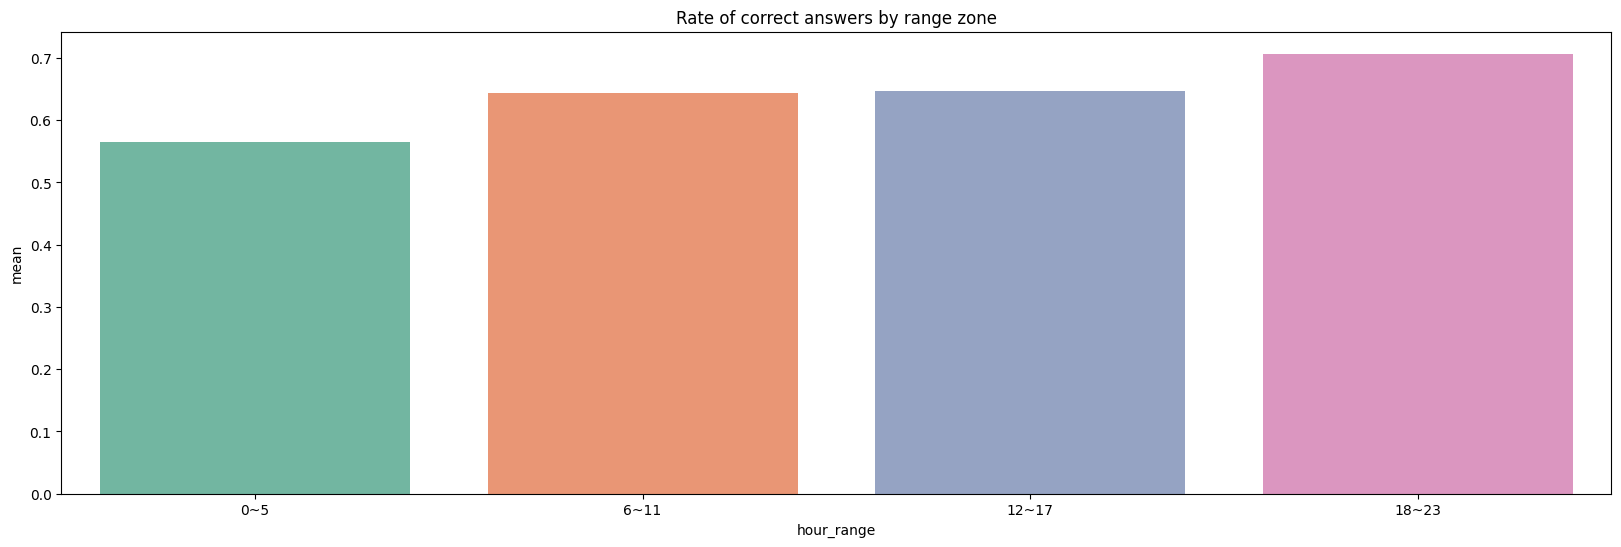

In [16]:
plt.figure(figsize=(20,6))
sns.barplot(x="hour_range", y="mean", data=Hour_range_ans_rate, palette='Set2')
plt.title('Rate of correct answers by range zone')
plt.show()

## knowledgetag

### baseline에서더 많이 노출된 태그가 정답률이 더 높은가?

### knowledgeTag를 1000단위로 나눠서 분류
가설 : 숫자가 가까운 knowledgeTag는 비슷한 유형일 것이다.

In [33]:
def tag_map(x: int) -> int:
    x = int(x)
    x = x // 1000
    return x

In [34]:
df_tag = df.copy()

df_tag['KnowledgeTag_cat'] = df_tag['KnowledgeTag'].apply(tag_map)
df_tag

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,elapsed,testCode,KnowledgeTag_cat
0,0,A060001001,A060000001,1,2020-03-24 09:17:11+09:00,7224,3.0,6,7
1,0,A060001002,A060000001,1,2020-03-24 09:17:14+09:00,7225,8.0,6,7
2,0,A060001003,A060000001,1,2020-03-24 09:17:22+09:00,7225,7.0,6,7
3,0,A060001004,A060000001,1,2020-03-24 09:17:29+09:00,7225,7.0,6,7
4,0,A060001005,A060000001,1,2020-03-24 09:17:36+09:00,7225,11.0,6,7
...,...,...,...,...,...,...,...,...,...
259365,7439,A040197006,A040000197,1,2020-08-21 16:39:45+09:00,2132,4721258.0,4,2
259366,7439,A040130001,A040000130,0,2020-10-15 08:07:23+09:00,8832,18.0,4,8
259367,7439,A040130002,A040000130,1,2020-10-15 08:07:41+09:00,8832,21.0,4,8
259368,7439,A040130003,A040000130,1,2020-10-15 08:08:02+09:00,8244,89.0,4,8


In [36]:
df_tag['KnowledgeTag_cat'].nunique()

12

tag에 따른 정답률 분포 확인

In [38]:
tag_groupby = df_tag.groupby('KnowledgeTag_cat').agg({
    'userID': 'count',
    'answerCode': percentile
})
tag_groupby

,userID,answerCode
KnowledgeTag_cat,,
0,440885,0.669835
1,214833,0.650854
2,360487,0.637366
3,88700,0.587542
4,154291,0.466378
5,169576,0.659858
6,118233,0.714462
7,463802,0.747315
8,250094,0.673227


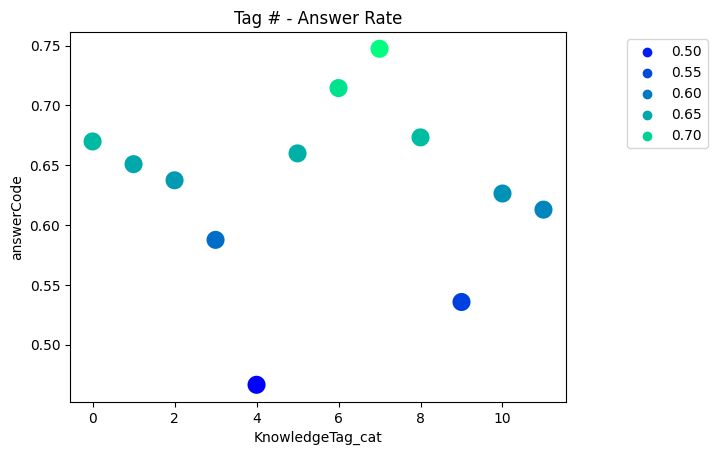

In [39]:
# tag에 대분류에 따른 정답률 그래프
g = sns.scatterplot(
    data=tag_groupby,
    x='KnowledgeTag_cat',
    y='answerCode',
    s = 200,
    hue = 'answerCode',
    palette = 'winter'
)
ax = plt.gca()
ax.set_title('Tag # - Answer Rate')
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1))

특정 유형 (4)은 비교적 낮은 정답률을, 특정 유형(7)은 비교적 높은 정답률을 보이는 것으로 보여진다.

## testcode + knowledgetag

In [40]:
tag_lv_groupby = df_tag.groupby(['KnowledgeTag_cat', 'testCode'])['answerCode'].apply(percentile)
tag_lv_groupby.sort_index(inplace=True)

tag_lv_groupby

KnowledgeTag_cat  testCode
0                 3           0.697570
                  5           0.658997
                  6           0.679022
                  7           0.565760
                  8           0.579117
                  9           0.475952
1                 3           0.718577
                  6           0.746007
                  7           0.496596
                  8           0.551092
                  9           0.471705
2                 4           0.675058
                  5           0.642791
                  8           0.491956
                  9           0.466955
3                 5           0.615919
                  7           0.517222
                  8           0.596000
4                 7           0.509412
                  8           0.469809
                  9           0.445201
5                 1           0.858432
                  5           0.671061
                  7           0.525278
                  9           0.45519

tag와 testcode 대분류에 따른 정답률 그래프

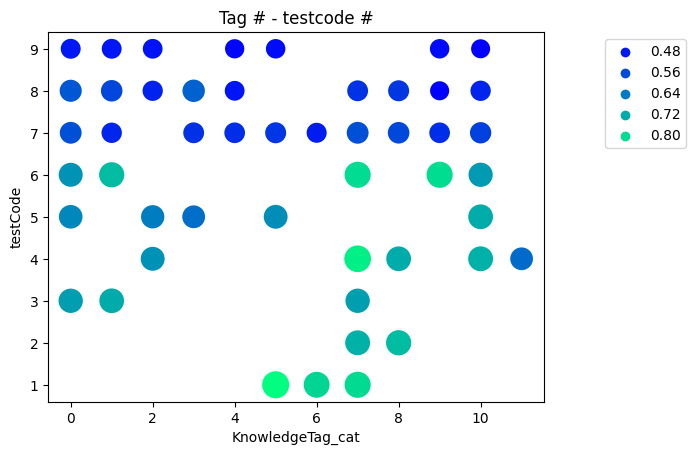

In [41]:
# 점의 크기 범위 설정
size_range = (10, 500)

# 점의 크기를 정확도 값에 비례하여 계산
point_size = size_range[0] + (size_range[1] - size_range[0]) * tag_lv_groupby

g = sns.scatterplot(
    data=tag_lv_groupby,
    x='KnowledgeTag_cat',
    y='testCode',
    s = point_size,
    hue = tag_lv_groupby,
    palette = 'winter',
    legend = 'brief'
)
ax = plt.gca()
ax.set_title('Tag # - testcode #')
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1))

## 기타

### testcode를 더 크게 범주화

In [29]:
def big_testcode_map(x:int) -> int:
    x = (x-1) // 3
    return x

In [30]:
df_bigcode = df.copy()

df_bigcode['bigtestCode'] = df_bigcode['testCode'].apply(big_testcode_map)
df_bigcode

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,elapsed,testCode,bigtestCode
0,0,A060001001,A060000001,1,2020-03-24 09:17:11+09:00,7224,3.0,6,1
1,0,A060001002,A060000001,1,2020-03-24 09:17:14+09:00,7225,8.0,6,1
2,0,A060001003,A060000001,1,2020-03-24 09:17:22+09:00,7225,7.0,6,1
3,0,A060001004,A060000001,1,2020-03-24 09:17:29+09:00,7225,7.0,6,1
4,0,A060001005,A060000001,1,2020-03-24 09:17:36+09:00,7225,11.0,6,1
...,...,...,...,...,...,...,...,...,...
259365,7439,A040197006,A040000197,1,2020-08-21 16:39:45+09:00,2132,4721258.0,4,1
259366,7439,A040130001,A040000130,0,2020-10-15 08:07:23+09:00,8832,18.0,4,1
259367,7439,A040130002,A040000130,1,2020-10-15 08:07:41+09:00,8832,21.0,4,1
259368,7439,A040130003,A040000130,1,2020-10-15 08:08:02+09:00,8244,89.0,4,1


In [31]:
bigcode_groupby = df_bigcode.groupby('bigtestCode').agg({'answerCode' : percentile, 'assessmentItemID': 'nunique'})
bigcode_groupby = bigcode_groupby.reset_index()

bigcode_groupby

,bigtestCode,answerCode,assessmentItemID
0,0,0.747388,3057
1,1,0.683586,3510
2,2,0.501555,2887


[Text(0.5, 1.0, 'Answer Rate by Big Test Code')]

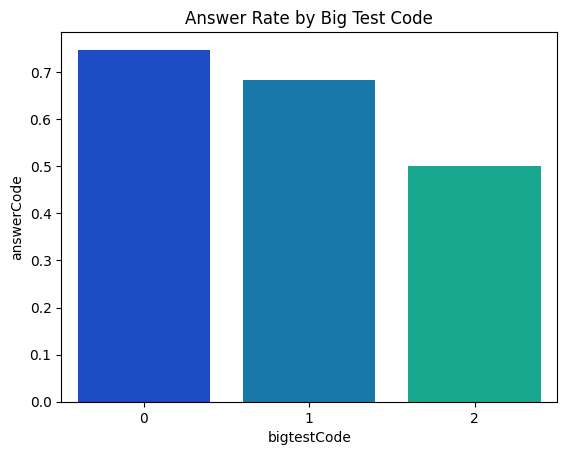

In [32]:
sns.barplot(x='bigtestCode', y='answerCode', data=bigcode_groupby, palette='winter').set(title='Answer Rate by Big Test Code')